In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import matplotlib
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import os, shutil, glob, subprocess
from scipy.interpolate import griddata


In [2]:
matplotlib.rc('font',size=17)

In [3]:
def grid_data(values):
    try:
        zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(values),xi,yi,interp='linear') 
    except:
        zi = griddata(points,np.log10(values),(xi,yi),method='linear') 
    return(zi)

In [4]:
#colour map setup
cmap = plt.cm.get_cmap("viridis")

my_cmap = cmap(np.arange(cmap.N))
alphas = np.linspace(0.6,0.6,cmap.N)
BG = np.asarray([1.,1.,1.])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG*(1.-alphas[i])
my_cmap = ListedColormap(my_cmap)
cmap=my_cmap

In [10]:
#User-defined values for the Av,obs - PDF shape and metallicity
av_bar = 6        # mean
s = 0.32            # width (sigma)
metallicity = 1   # allowed values: 0.1, 0.5, 1.0, 2.0
#any other metallicity value will return a "512" signal and the algorithm won't run
if metallicity not in [0.1, 0.5, 1.0, 2.0]: 
    print('ERROR: Allowed metallicity values are: 0.1, 0.5, 1, 2!')
    exit

In [11]:
writeout = np.column_stack((av_bar,s,metallicity))
np.savetxt('pdfchem.params',writeout,delimiter=' ',fmt='%1.4e')

In [12]:
# Check if there are AV-PDF file(s) provided by the user

avpdf_dir =  os.path.join('..', 'crop_image', '200pixel_pdf')
#avpdf_dir =  os.path.join('..', 'avpdfs')
avpdf_files= glob.glob(os.path.join(avpdf_dir,'*.dat'))
avpdf_file = os.path.join(avpdf_dir,'avpdf_input_20_10.dat')
pdfchem_output_file = os.path.join(f'pdfchem_outputs', 'output_20_10.dat')
pdf_i =  avpdf_file.split('/')[-1].split('.')[0][-6:]

if os.path.exists(avpdf_file):
    print(f'User PDF data file available.')
    pdf_type = 'user'
    subprocess.call(['./pdfchem_algorithm_PDFinput_fullG', avpdf_file, pdfchem_output_file])
    #subprocess.call(['./pdfchem_algorithm_PDFinput', avpdf_file, pdfchem_output_file])
else:
    print(f'Making a PDF based on parameters av_bar={av_bar} and width={s}.')
    pdf_type = 'model'
    subprocess.call(['./pdfchem_algorithm_PDFinput'])
    subprocess.call('./pdfchem_algorithm.py',shell=True)


Making a PDF based on parameters av_bar=6 and width=0.32.
 No input file and output file provided. Will create a simulated PDF


./pdfchem_algorithm.py: 1: import: not found
./pdfchem_algorithm.py: 2: import: not found
./pdfchem_algorithm.py: 3: import: not found
./pdfchem_algorithm.py: 4: import: not found
: not foundlgorithm.py: 5: 
: not foundlgorithm.py: 6: 
./pdfchem_algorithm.py: 7: pc2cm: not found
./pdfchem_algorithm.py: 8: mhp: not found
./pdfchem_algorithm.py: 9: Syntax error: "(" unexpected


In [89]:
#np.loadtxt(avpdf_file)
#if '/' in 'Tco21/Tco10': 'Tco21/Tco10'.replace('/','_to_')

#if os.path.exists(avpdf_files[0]): print(1)

In [90]:
#You need to compile the algorithm (using gfortran) first to be able to run it
#Compiling the algorithm: in a terminal and while in the directory of PDFchem,
#                         type 'gfortran -o pdfchem_algorithm pdfchem_algorithm.f90'
#os.system('./pdfchem_algorithm_PDFinput')
#successful runs return "0" signal after ~30 seconds depending on your machine

In [91]:
# read the output from the algorithm
inputfile = 'output.dat'
#inputfile = pdfchem_output_file
title = r'PDFchem result'

In [92]:
#CHEMISTRY RESULTS
d = np.genfromtxt(inputfile)

#UV radiation (Draine); cosmic-ray ionization rate (s-1); metallicity (Zsolar)
UV = d[:,0]; CR = d[:,1]; Z = d[:,2]
#Gas temperature
Tgas = d[:,3]
#Abundances of CII; CI; CO; OI; HI; H2; OH+; H2O+; OH; CH; HCO+
CII = d[:,14]; CI = d[:,28]; CO = d[:,31]
OI = d[:,33]; HI = d[:,35]; H2 = d[:,34]
OHp = d[:,12]; H2Op = d[:,16]; OH = d[:,32]
CH = d[:,24]; HCOp = d[:,26]
#the above are some of the available species
#follow the sequence of species by adding 3 to plot any other available

#Brightness temperatures of [CII]158; [CI](1-0); [CI](2-1)
Tcii = d[:,37]; Tci10 = d[:,38]; Tci21 = d[:,39]
#CO(1-0); CO(2-1); ... CO(10-9)
Tco10 = d[:,40]; Tco21 = d[:,41]; Tco32 = d[:,42] 
Tco43 = d[:,43]; Tco54 = d[:,44]; Tco65 = d[:,45]
Tco76 = d[:,46]; Tco87 = d[:,47]; Tco98 = d[:,48]
Tco109 = d[:,49]


#AV-PDF 
try:
    d = np.genfromtxt(avpdf_file)  # user specified PDF
    av = d[:,0]; pdf = d[:,1]
    av_bar = 'user AV-PDF'
    s = '*'
    #av = 10**d[:,0]
except:
    d = np.genfromtxt('avpdf.dat')       # program generated PDF
d_model = np.genfromtxt('avpdf.dat')       # program generated PDF
av_m = d_model[:,0]; pdf_m = d_model[:,1]

In [93]:
inputfile

'output.dat'

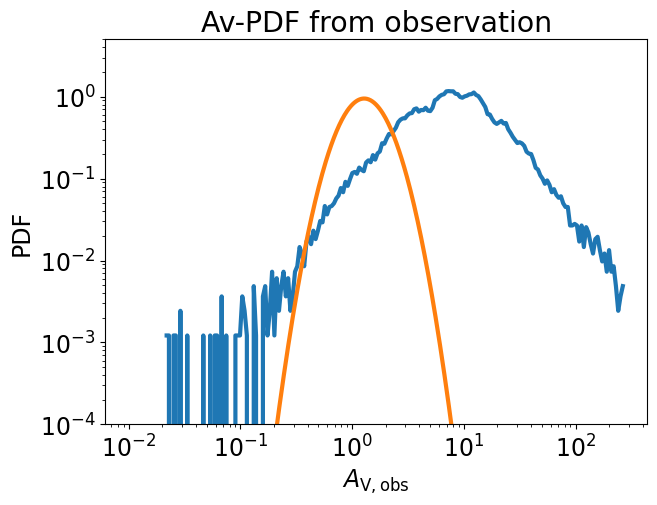

In [94]:
#Plot the user-defined Av,obs -- PDF

fig,ax = plt.subplots(figsize=(7,5))
plt.loglog(av,pdf,'-',lw=3)
plt.loglog(av_m,pdf_m,'-',lw=3)
ax.set_ylim(1e-4,5)
plt.xlabel(r'$A_{\rm V,obs}$')
plt.ylabel(r'PDF')
if pdf_type == 'user':
    plt.title('Av-PDF from observation')
if pdf_type == 'model':
    plt.title(f'Mean={av_bar}, width={s}')
#pdf_fig_path = os.path.join('Fig_pdf', 'PDF_{}.png'.format(pdf_i))
#plt.savefig(pdf_fig_path, bbox_inches='tight')

In [95]:
#for plotting the grid
xi = np.linspace(min(np.log10(CR)), max(np.log10(CR)), 50)
yi = np.linspace(min(np.log10(UV)), max(np.log10(UV)), 50)
points = np.array([np.log10(CR),np.log10(UV)]).T

Text(0.5, 0.95, 'CO10')

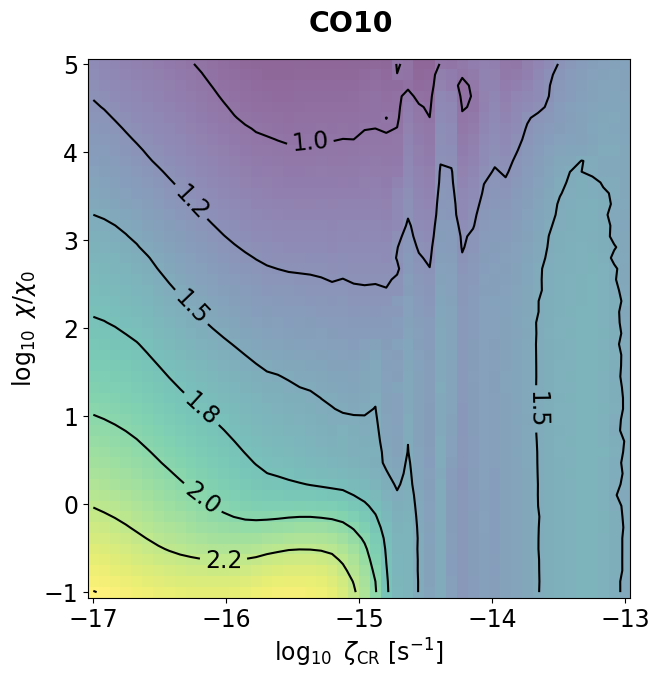

In [96]:
#Individual plot

#Enter quantity to plot (ratios are generally preferred, especially
#                        for brightness temperatures)
qty = Tco10 # e.g. 'CO' for CO abundance, 'Tco21/Tco10' for CO(2-1)/CO(1-0)
title = r'CO10'

plt.figure(figsize=(7,7))
N=6 #No. contours

try:
    #HI-H2 transition
    zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 
    #make grid of the quantity qty
    zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(qty),xi,yi,interp='linear')
except:        # in newer versions of matplotlib there isn't mlab.griddata(), so use scipy instead:
    xi,yi = np.mgrid[min(np.log10(CR)):max(np.log10(CR)):50j, min(np.log10(UV)):max(np.log10(UV)):50j]
    zi_tr = griddata(points,np.log10(HI/2./H2),(xi,yi),method='linear') 
    zi = griddata(points,np.log10(qty),(xi,yi),method='linear')

dir_output = 'CO21_to_CO10'
plt.pcolormesh(xi,yi,zi,cmap=cmap)
CS = plt.contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
#plt.contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0) #plot HI-H2 transition (red line)
plt.xticks([-17,-16,-15,-14,-13])
plt.yticks([-1,0,1,2,3,4,5])
plt.xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
plt.ylabel(r'$\log_{10}\,\,\chi/\chi_0$')
plt.suptitle(title,weight='bold',y=0.95)

#individual_fig_path = os.path.join('Fig_{}.format(dir_output)', '{}_{}.png'.format(dir_output, pdf_i))
#plt.savefig(individual_fig_path, bbox_inches='tight')

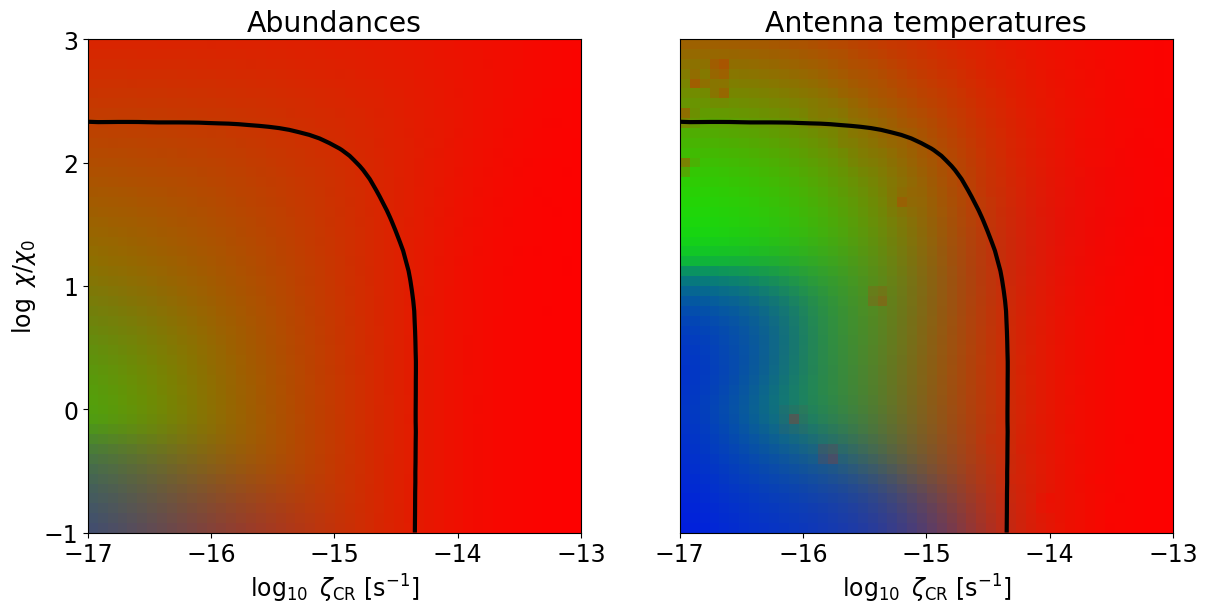

In [84]:
#carbon cycle map
fig, axs = plt.subplots(1,2,figsize=(14,7))

#HI-H2 transition
try:
    zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 
except:
    zi_tr = griddata(points,np.log10(HI/2./H2),(xi,yi),method='linear') 

#RED: CII and [CII]
#GREEN: CI and [CI](1-0)
#BLUE: CO and CO(1-0)

#Abundances
tot_carbon = CII+CI+CO
try:
    cii_norm = ml.griddata(np.log10(CR),np.log10(UV),CII/tot_carbon,xi,yi,interp='linear')
    ci_norm = ml.griddata(np.log10(CR),np.log10(UV),CI/tot_carbon,xi,yi,interp='linear')
    co_norm = ml.griddata(np.log10(CR),np.log10(UV),CO/tot_carbon,xi,yi,interp='linear')
except:
    cii_norm = griddata(points,CII/tot_carbon,(xi,yi),method='linear')
    ci_norm = griddata(points,CI/tot_carbon,(xi,yi),method='linear')
    co_norm = griddata(points,CO/tot_carbon,(xi,yi),method='linear')

axs[0].imshow(np.dstack([cii_norm,ci_norm,co_norm]),origin='lower',extent=[-17,-13,-1,3])
axs[0].contour(xi,yi,zi_tr,[0],colors='k',linewidths=3.0)
axs[0].set_xticks([-17,-16,-15,-14,-13])
axs[0].set_yticks([-1,0,1,2,3])
axs[0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[0].set_xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[0].set_title(r'Abundances')

#Abundances
tot_Tcarbon = Tcii+Tci10+Tco10
try:
    cii_norm = ml.griddata(np.log10(CR),np.log10(UV),Tcii/tot_Tcarbon,xi,yi,interp='linear')
    ci_norm = ml.griddata(np.log10(CR),np.log10(UV),Tci10/tot_Tcarbon,xi,yi,interp='linear')
    co_norm = ml.griddata(np.log10(CR),np.log10(UV),Tco10/tot_Tcarbon,xi,yi,interp='linear')
except:
    cii_norm = griddata(points,Tcii/tot_Tcarbon,(xi,yi),method='linear')
    ci_norm = griddata(points,Tci10/tot_Tcarbon,(xi,yi),method='linear')
    co_norm = griddata(points,Tco10/tot_Tcarbon,(xi,yi),method='linear')

axs[1].imshow(np.dstack([cii_norm,ci_norm,co_norm]),origin='lower',extent=[-17,-13,-1,3])
axs[1].contour(xi,yi,zi_tr,[0],colors='k',linewidths=3.0)
axs[1].set_xticks([-17,-16,-15,-14,-13])
axs[1].set_yticks([])
axs[1].set_xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[1].set_title(r'Antenna temperatures')

Carbon_fig_path = os.path.join('Fig_Carbon', 'Carbon_map_{}.png'.format(pdf_i))
plt.savefig(Carbon_fig_path, bbox_inches='tight')

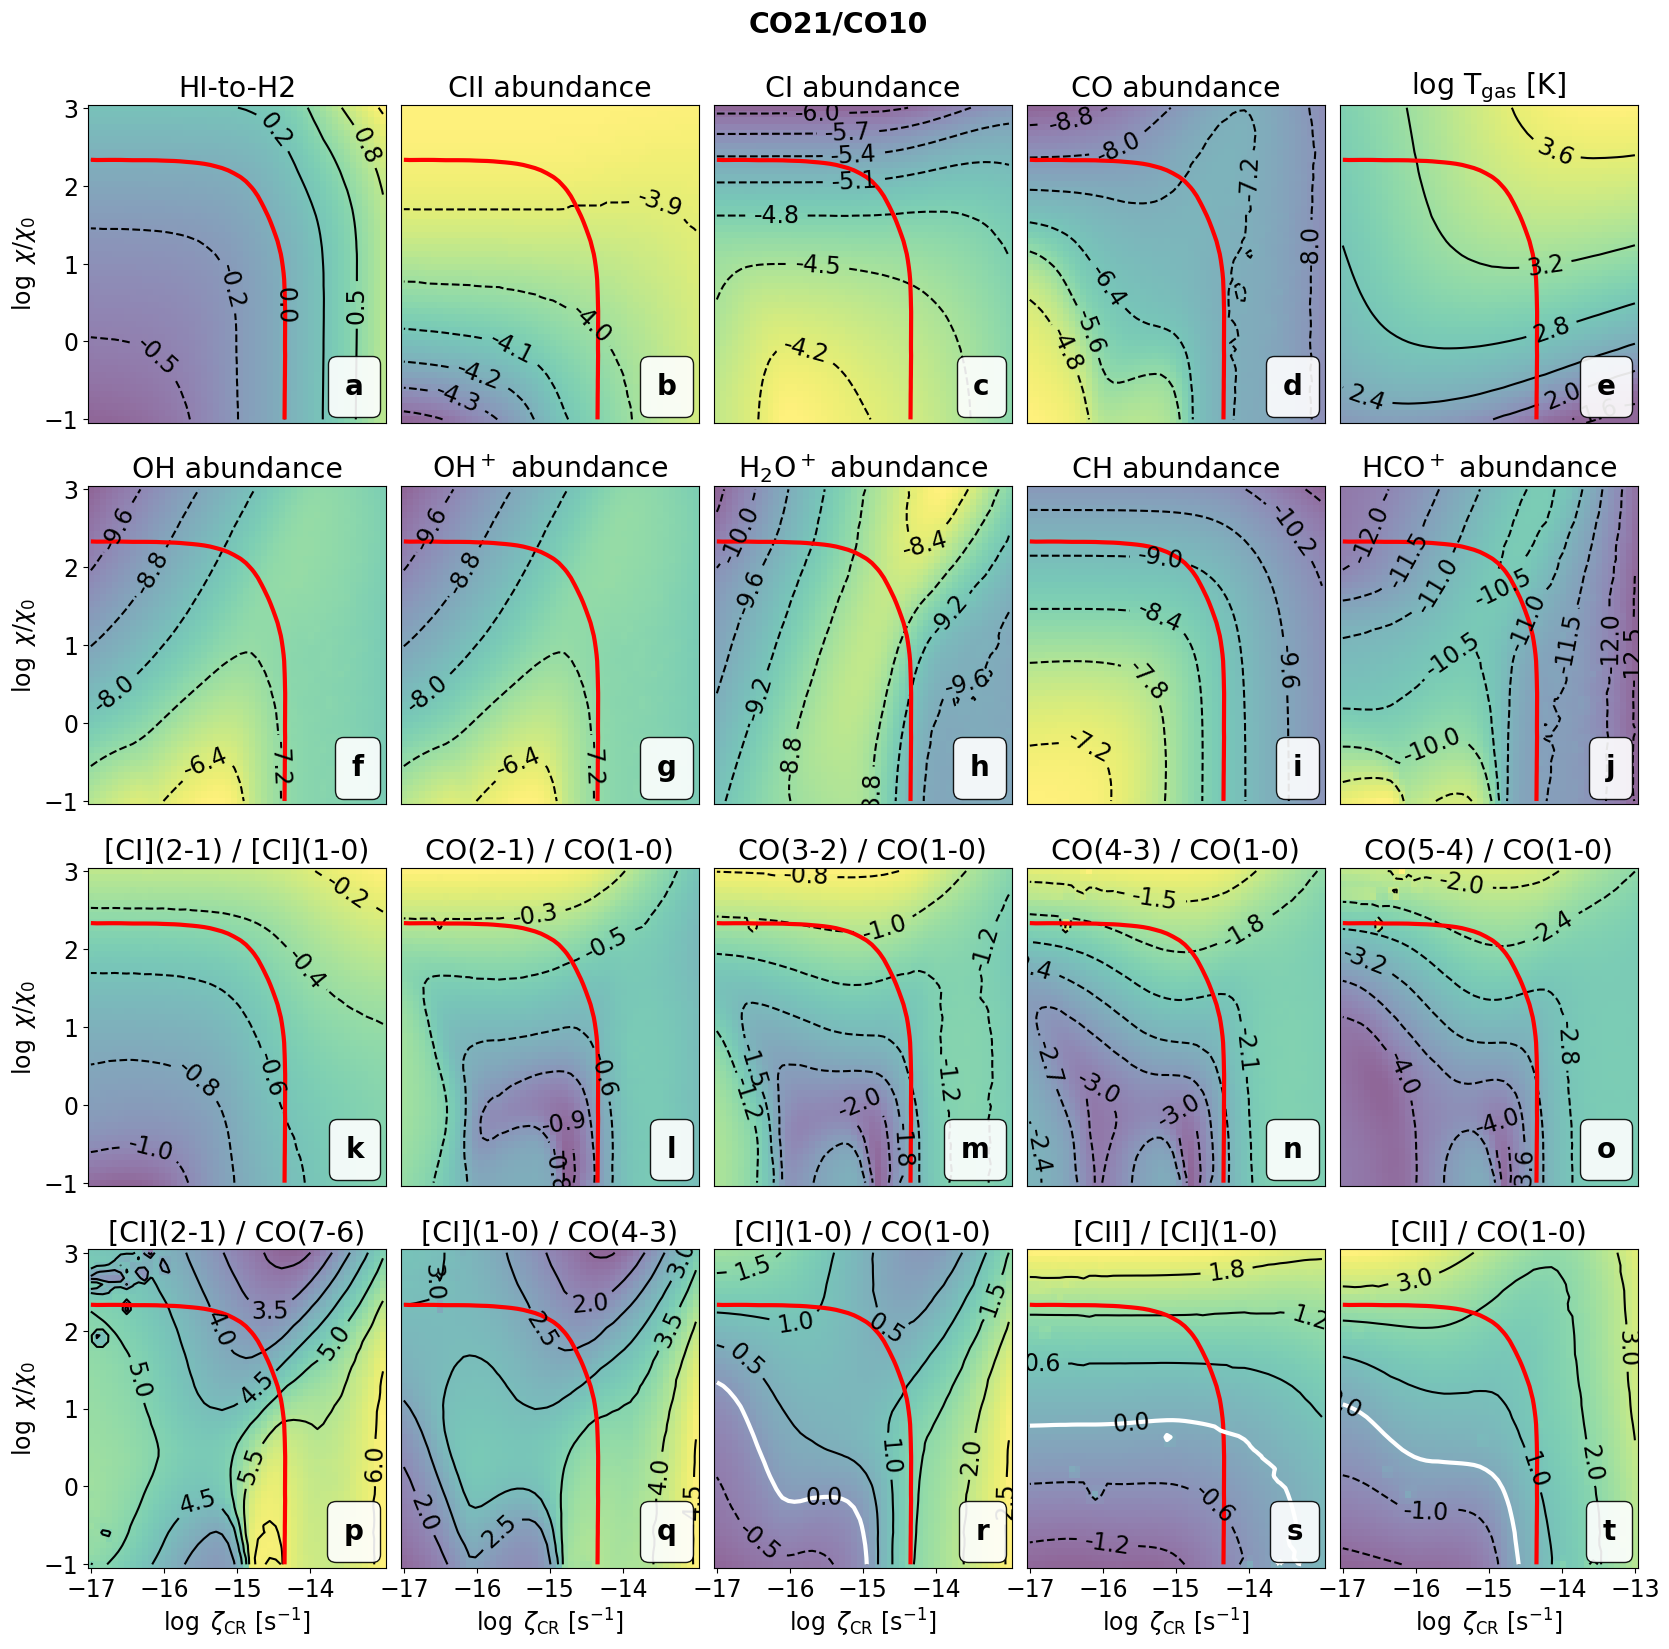

In [85]:
# Importing warnings
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')


#Collective plot similar to paper

fig, axs = plt.subplots(4, 5, figsize=(20,19))

xt = -16.85; yt = -0.65
N=6

#zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear')
zi_tr = grid_data(HI/2./H2)
axs[0,0].pcolormesh(xi,yi,zi_tr,cmap=cmap)
CS = axs[0,0].contour(xi,yi,zi_tr,N,colors='k')
axs[0,0].clabel(CS,fmt='%1.1f')
CS = axs[0,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("a", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,0].add_artist(text_box)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([-1, 0, 1, 2, 3])
axs[0,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[0,0].set_title('HI-to-H2')

#zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CII),xi,yi,interp='linear')
zi = grid_data(CII)
axs[0,1].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,1].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("b", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,1].add_artist(text_box)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('CII abundance')

#zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CI),xi,yi,interp='linear')
zi = grid_data(CI)
axs[0,2].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,2].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("c", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,2].add_artist(text_box)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('CI abundance')

#zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CO),xi,yi,interp='linear')
zi = grid_data(CO)
axs[0,3].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,3].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("d", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,3].add_artist(text_box)
axs[0,3].set_xticks([])
axs[0,3].set_yticks([])
axs[0,3].set_title('CO abundance')

#zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tgas),xi,yi,interp='linear')
zi = grid_data(Tgas)
axs[0,4].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,4].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("e", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,4].add_artist(text_box)
axs[0,4].set_xticks([])
axs[0,4].set_yticks([])
axs[0,4].set_title(r'log T$_{\rm gas}$ [K]')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OH),xi,yi,interp='linear')
zi_R = grid_data(OH)
axs[1,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("f", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,0].add_artist(text_box)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([-1, 0, 1, 2, 3])
axs[1,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[1,0].set_title('OH abundance')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OHp),xi,yi,interp='linear')
zi = grid_data(OHp)
axs[1,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("g", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,1].add_artist(text_box)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].set_title(r'OH$^+$ abundance')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(H2Op),xi,yi,interp='linear')
zi_R = grid_data(H2Op)
axs[1,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("h", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,2].add_artist(text_box)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])
axs[1,2].set_title(r'H$_2$O$^+$ abundance')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CH),xi,yi,interp='linear')
zi_R = grid_data(CH)
axs[1,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("i", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,3].add_artist(text_box)
axs[1,3].set_xticks([])
axs[1,3].set_yticks([])
axs[1,3].set_title('CH abundance')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HCOp),xi,yi,interp='linear')
zi_R = grid_data(HCOp)
axs[1,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("j", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,4].add_artist(text_box)
axs[1,4].set_xticks([])
axs[1,4].set_yticks([])
axs[1,4].set_title(r'HCO$^+$ abundance')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tci10),xi,yi,interp='linear')
zi_R = grid_data(Tci21/Tci10)
axs[2,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("k", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,0].add_artist(text_box)
axs[2,0].set_xticks([])
axs[2,0].set_yticks([-1, 0, 1, 2, 3])
axs[2,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[2,0].set_title('[CI](2-1) / [CI](1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco21/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tco21/Tco10)
axs[2,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("l", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,1].add_artist(text_box)
axs[2,1].set_xticks([])
axs[2,1].set_yticks([])
axs[2,1].set_title('CO(2-1) / CO(1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco32/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tco32/Tco10)
axs[2,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("m", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,2].add_artist(text_box)
axs[2,2].set_xticks([])
axs[2,2].set_yticks([])
axs[2,2].set_title('CO(3-2) / CO(1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco43/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tco43/Tco10)
axs[2,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("n", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,3].add_artist(text_box)
axs[2,3].set_xticks([])
axs[2,3].set_yticks([])
axs[2,3].set_title('CO(4-3) / CO(1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco54/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tco54/Tco10)
axs[2,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("o", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,4].add_artist(text_box)
axs[2,4].set_xticks([])
axs[2,4].set_yticks([])
axs[2,4].set_title(r'CO(5-4) / CO(1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tco76),xi,yi,interp='linear')
zi_R = grid_data(Tci21/Tco76)
axs[3,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("p", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,0].add_artist(text_box)
axs[3,0].set_xticks([-17, -16, -15, -14])
axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,0].set_yticks([-1, 0, 1, 2, 3])
axs[3,0].set_title(r'[CI](2-1) / CO(7-6)')
axs[3,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco43),xi,yi,interp='linear')
zi_R = grid_data(Tci10/Tco43)
axs[3,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("q", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,1].add_artist(text_box)
axs[3,1].set_xticks([-17, -16, -15, -14])
axs[3,1].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,1].set_yticks([])
axs[3,1].set_title(r'[CI](1-0) / CO(4-3)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tci10/Tco10)
axs[3,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("r", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,2].add_artist(text_box)
axs[3,2].set_xticks([-17, -16, -15, -14])
axs[3,2].set_yticks([])
axs[3,2].set_title(r'[CI](1-0) / CO(1-0)')
axs[3,2].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tci10),xi,yi,interp='linear')
zi_R = grid_data(Tcii/Tci10)
axs[3,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("s", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,3].add_artist(text_box)
axs[3,3].set_xticks([-17, -16, -15, -14])
axs[3,3].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,3].set_yticks([])
axs[3,3].set_title(r'[CII] / [CI](1-0)')

#zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tco10),xi,yi,interp='linear')
zi_R = grid_data(Tcii/Tco10)
axs[3,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("t", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,4].add_artist(text_box)
axs[3,4].set_xticks([-17, -16, -15, -14, -13])
axs[3,4].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,4].set_yticks([])
axs[3,4].set_title(r'[CII] / CO(1-0)')


plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.suptitle(title, y=0.93, weight='bold')

collective_fig_path = os.path.join('Fig_Collective', 'Collective_{}.png'.format(pdf_i))
plt.savefig(collective_fig_path, bbox_inches='tight')